In [1]:
from pathlib import Path
import functions as funcs
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd
import pickle
from yolo_few_shot import Yolo_N_Shot, get_prototypes
from keras.models import Model
from keras.applications.vgg16 import VGG16

- 5-way-2-shot classification -> 5 classes 2 images per class
- Only 2 Basofils in the training set

In [2]:
root_path = Path().cwd().parent
few_shot_dir_path = Path()/ root_path/"Few_Shot"

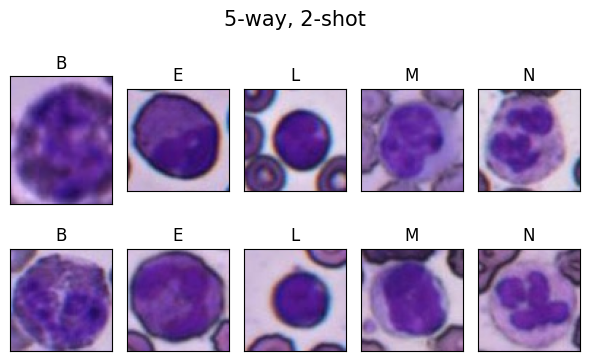

In [3]:
import pathlib
import matplotlib.pyplot as plt

# Count the number of directories
k_way = len([folder for folder in few_shot_dir_path.iterdir() if folder.is_dir()])

# Assuming you want to set n_shot to the maximum number of files in any directory
n_shot = max([len(list(folder.iterdir())) for folder in few_shot_dir_path.iterdir() if folder.is_dir()])

fig, axs = plt.subplots(nrows=n_shot, ncols=k_way, figsize=(6, 4))
fig.suptitle(f"{k_way}-way, {n_shot}-shot", fontsize=15)

for col, class_dir in enumerate(few_shot_dir_path.iterdir()):
    if class_dir.is_dir():
        class_name = class_dir.parts[-1]
        for row, file in enumerate(class_dir.iterdir()):
            img = funcs.get_image_from_path(file_path=file)
            axs[row, col].imshow(img)
            axs[row, col].set_title(class_name)
            axs[row, col].set_xticks([])
            axs[row, col].set_yticks([])

plt.tight_layout()
plt.show()


In [4]:
wbc_class = ["Neutrophil", "Lymphocyte", "Monocyte", "Eosinophil", "Basophil"]

model = VGG16(weights='imagenet', include_top=True)
feat_extractor = Model(inputs=model.input, outputs=model.get_layer("fc2").output)

In [5]:
prototypes = get_prototypes(few_shot_folder_path=few_shot_dir_path, feature_extractor=feat_extractor, class_list=wbc_class)

In [6]:
y2s = Yolo_N_Shot(yolo_weights_path='../Yolo/best.pt', 
                      class_list=wbc_class, 
                      feature_extractor=feat_extractor, 
                      prototypes=prototypes)

In [7]:
test_images_folder = root_path / 'Yolo'/ 'test'/'images'
test_images_paths = [image_path for image_path in test_images_folder.iterdir() if image_path.is_file()]

In [ ]:
test_results = [y2s.predict(image_path=image_path) for image_path in test_images_paths]

In [43]:
test_results[2]

PredictionResult(predicted_classes=['Neutrophil', 'Lymphocyte'], predicted_scores=[0.541, 0.72], boxes_xyxy=[array([ 17, 846,  92, 922]), array([778, 154, 846, 222])], center_x_y_norm=[[0.054730818, 0.88471204], [0.8125559, 0.18855242]], path=WindowsPath('c:/Users/singh/OneDrive/MSc_in_AI/Python/Zooinverse/Yolo/test/images/A014_18Z_T15092_MID_x40_z0_i09j08.jpg'))

In [46]:
test_results[2].predicted_classes

['Neutrophil', 'Lymphocyte']

In [266]:
from yolo_few_shot import PredictionResult
from result_evaluation import get_ground_from_label_file, calculate_distance, get_precision_recall_f1, calculate_class_metrics
from collections import defaultdict

In [54]:
def calculate_class_metrics_yolo_shot(pred_results_list:list[PredictionResult], 
                                      label_folder_path:Path, 
                                      class_list:list[str]) -> dict:
    """ Calculates the total number of true-positive, true-native & false-positives 
        from a results list by comparing it to the ground truth for classes only 
        ================================================================================
        For every result box value -> finds the closest ground value using Euclidean distance, then:
        - If there are more predictions than ground values -> false-positive
        - If prediction != ground -> false-positive
        - If prediction == ground -> true-positive
        - If more ground values than predictions -> false-negative
    """
    class_metrics = {cls_name:{'true_positive':0, 'false_positive':0, 'false_negative':0} for cls_name in class_list}
    for pred_result in pred_results_list:
        image_name = Path(pred_result.path).parts[-1].split(".")[0] + ".txt"
        ground_truth = get_ground_from_label_file(label_folder_path=label_folder_path,
                                                  image_name=image_name,
                                                  class_list=class_list)
        preds = [{'class':cls,'x':x,'y': y} 
                 for cls, (x,y) in zip(pred_result.predicted_classes,
                                       pred_result.center_x_y_norm)]
        # calculate the distace between all predictions and ground
        closest_ground_pred_pairing = defaultdict(int)
        for i, pred in enumerate(preds):
            closest_ground_idx = None
            closest_ground_dist = np.inf
            for j, ground in enumerate(ground_truth):
                dist = calculate_distance(pt1=(pred['x'], pred['y']), pt2=(ground['x'], ground['y']))
                if dist < closest_ground_dist:
                    closest_ground_dist = dist
                    closest_ground_idx = j
            closest_ground_pred_pairing[closest_ground_idx] = i
        # Check metrics
        preds_with_ground = closest_ground_pred_pairing.values()
        preds_without_ground = list(set(np.arange(len(preds))) - set(preds_with_ground))
        # More predictions than ground -> false positives
        for lonely_pred in preds_without_ground:
            lonely_pred_class = preds[lonely_pred]['class']
            class_metrics[lonely_pred_class]['false_positive'] += 1
        for ground_idx, pred_idx in closest_ground_pred_pairing.items():
            ground_class = ground_truth[ground_idx]['class']
            pred_class = preds[pred_idx]['class']
            # if pred class == ground class -> true positive
            if ground_class == pred_class:
                class_metrics[pred_class]['true_positive'] += 1
            # if pred class != ground class -> false positive
            else:
                class_metrics[pred_class]['false_positive'] += 1
        # More ground than pred -> false negatives
        lonely_grounds = list(set(np.arange(len(ground_truth))) - set(closest_ground_pred_pairing.keys()))
        for ground_idx in lonely_grounds:
            ground_class = ground_truth[ground_idx]['class']
            class_metrics[ground_class]['false_negative'] += 1

    return class_metrics

In [55]:
label_folder_path = root_path / 'Yolo'/ 'test'/ 'labels'

class_mets = calculate_class_metrics_yolo_shot(pred_results_list=test_results, 
                                  label_folder_path=label_folder_path, 
                                  class_list=wbc_class)

In [56]:
class_mets

{'Neutrophil': {'true_positive': 63,
  'false_positive': 22,
  'false_negative': 0},
 'Lymphocyte': {'true_positive': 18,
  'false_positive': 39,
  'false_negative': 0},
 'Monocyte': {'true_positive': 0, 'false_positive': 15, 'false_negative': 0},
 'Eosinophil': {'true_positive': 2, 'false_positive': 5, 'false_negative': 0},
 'Basophil': {'true_positive': 0, 'false_positive': 3, 'false_negative': 0}}

In [58]:
overall_precision, overall_recall, overall_f1_score = get_precision_recall_f1(class_metrics=class_mets)
overall_precision, overall_recall, overall_f1_score

(0.497, 1.0, 0.664)

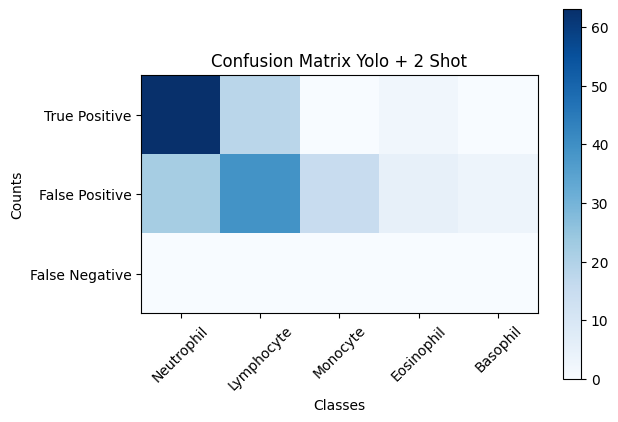

In [259]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Confusion matrix data
data = {
    'Neutrophil': {'true_positive': 63, 'false_positive': 22, 'false_negative': 0},
    'Lymphocyte': {'true_positive': 18, 'false_positive': 39, 'false_negative': 0},
    'Monocyte': {'true_positive': 0, 'false_positive': 15, 'false_negative': 0},
    'Eosinophil': {'true_positive': 2, 'false_positive': 5, 'false_negative': 0},
    'Basophil': {'true_positive': 0, 'false_positive': 3, 'false_negative': 0}
}

# Extract true positive, false positive, and false negative values for each class
true_positive = [data[class_name]['true_positive'] for class_name in data]
false_positive = [data[class_name]['false_positive'] for class_name in data]
false_negative = [data[class_name]['false_negative'] for class_name in data]

# Create confusion matrix for each class
conf_matrix = np.array([true_positive, false_positive, false_negative])

# Plot confusion matrix
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix Yolo + 2 Shot')
plt.colorbar()

classes = ['Neutrophil', 'Lymphocyte', 'Monocyte', 'Eosinophil', 'Basophil']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(np.arange(3), ['True Positive', 'False Positive', 'False Negative'])

plt.ylabel('Counts')
plt.xlabel('Classes')
plt.show()


In [76]:
test_results[2]

PredictionResult(predicted_classes=['Neutrophil', 'Lymphocyte'], predicted_scores=[0.541, 0.72], boxes_xyxy=[array([ 17, 846,  92, 922]), array([778, 154, 846, 222])], center_x_y_norm=[[0.054730818, 0.88471204], [0.8125559, 0.18855242]], path=WindowsPath('c:/Users/singh/OneDrive/MSc_in_AI/Python/Zooinverse/Yolo/test/images/A014_18Z_T15092_MID_x40_z0_i09j08.jpg'))

In [112]:
import matplotlib.patches as patches


In [147]:
def plot_pred_ground(pred:PredictionResult, folder_path:Path, class_list:list[str]) -> None:
    label_name = pred.path.parts[-1].split(".")[0] + ".txt"
    ground_truth = get_ground_from_label_file(label_folder_path=folder_path,
                                                  image_name=label_name,
                                                  class_list=class_list)
    print(ground_truth)
    assert pred.path.is_file(), "File not found"
    img = funcs.get_image_from_path(file_path=pred.path)

    colors = {cell: color  for cell, color in zip(['Neutrophil', 'Lymphocyte', 'Monocyte', 'Eosinophil', 'Basophil'],
                                                 ['red', 'yellow', 'lightgreen', 'lightblue', 'pink'])}
    
    _, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
    ax[0].set_title("Ground")
    ax[0].imshow(img)
    for ground in ground_truth:
        center_x = int(ground['x'] * 1000)
        center_y = int(ground['y'] * 1000)
        ax[0].scatter(x=center_x, y=center_y, s=500, label=ground['class'], facecolors='none', edgecolors=colors.get(ground['class'], 'black'))
        ax[0].legend(bbox_to_anchor=(0.5,-0.10), loc='lower center', ncol=5)
        ax[0].axis('off')

    ax[1].imshow(img)
    ax[1].set_title('Predictions')
    ax[1].axis('off')
    for box, cls, score in zip(pred.boxes_xyxy, pred.predicted_classes, pred.predicted_scores):
        ax[1].add_patch(plt.Rectangle(xy=(box[0], box[1]), width=box[2] - box[0], height=box[3] - box[1],
                             linewidth=1, edgecolor=colors[cls], facecolor='none'))
        ax[1].text(x=box[0], y=box[1]-20, s=f'{cls}:{score:.2f}', bbox=dict(facecolor=colors[cls], alpha=0.5,edgecolor='none'))


    plt.tight_layout()
    plt.show()
        
    

In [154]:
inds = (i for i in range(len(test_results)))

[{'class': 'Neutrophil', 'x': 0.04, 'y': 0.623}]


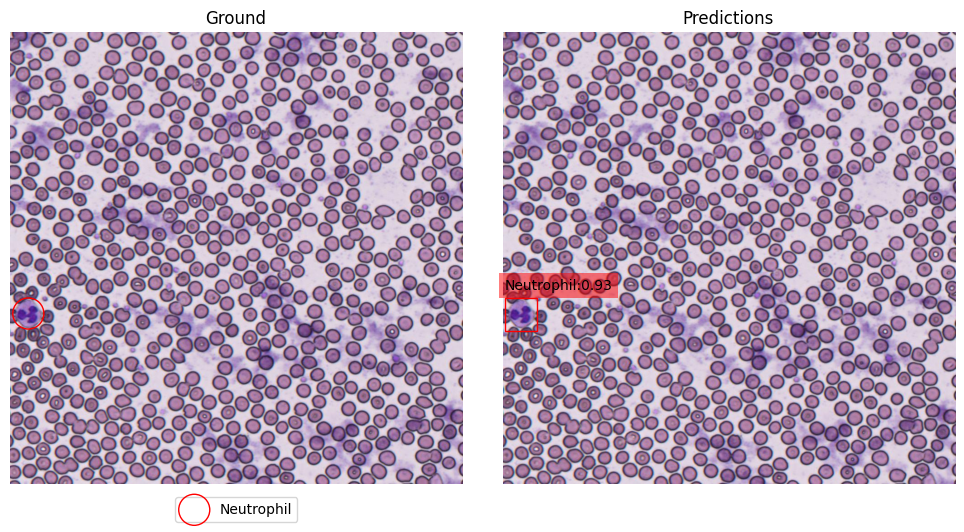

In [258]:
plot_pred_ground(pred=test_results[next(inds)], folder_path=label_folder_path, class_list=wbc_class)

Yolo only

In [260]:
from ultralytics import YOLO

In [264]:
yolo_model = YOLO(model=root_path/"Yolo"/"best.pt")

In [ ]:
yolo_results = [yolo_model.predict(source=image_path) for image_path in test_images_paths]

In [273]:
yolo_results = [inner_list[0] for inner_list in yolo_results]

In [275]:
yolo_class_metrics = calculate_class_metrics(pred_results_list=yolo_results, label_folder_path=root_path/'Yolo'/'test'/'labels')
yolo_class_metrics

{'Neutrophil': {'true_positive': 79,
  'false_positive': 18,
  'false_negative': 0},
 'Lymphocyte': {'true_positive': 19,
  'false_positive': 14,
  'false_negative': 0},
 'Monocyte': {'true_positive': 11, 'false_positive': 19, 'false_negative': 0},
 'Eosinophil': {'true_positive': 2, 'false_positive': 5, 'false_negative': 0},
 'Basophil': {'true_positive': 0, 'false_positive': 0, 'false_negative': 0}}

In [276]:
yolo_precision, yolo_recall, yolo_f1_score = get_precision_recall_f1(class_metrics=yolo_class_metrics)
yolo_precision, yolo_recall, yolo_f1_score

(0.6647, 1.0, 0.7986)

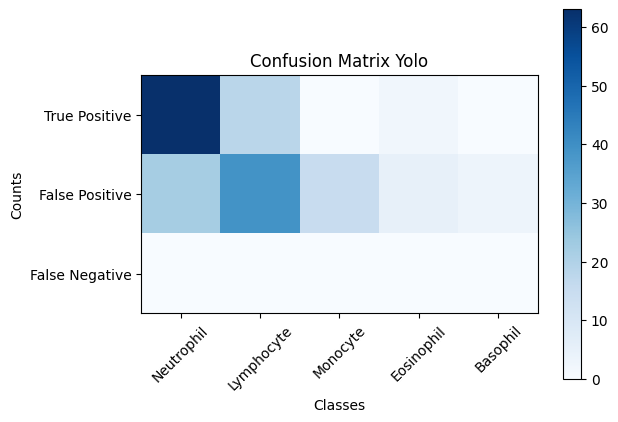

In [277]:
# Confusion matrix data
yolo_class_metrics = {
    'Neutrophil': {'true_positive': 63, 'false_positive': 22, 'false_negative': 0},
    'Lymphocyte': {'true_positive': 18, 'false_positive': 39, 'false_negative': 0},
    'Monocyte': {'true_positive': 0, 'false_positive': 15, 'false_negative': 0},
    'Eosinophil': {'true_positive': 2, 'false_positive': 5, 'false_negative': 0},
    'Basophil': {'true_positive': 0, 'false_positive': 3, 'false_negative': 0}
}

# Extract true positive, false positive, and false negative values for each class
true_positive = [yolo_class_metrics[class_name]['true_positive'] for class_name in yolo_class_metrics]
false_positive = [yolo_class_metrics[class_name]['false_positive'] for class_name in yolo_class_metrics]
false_negative = [yolo_class_metrics[class_name]['false_negative'] for class_name in yolo_class_metrics]

# Create confusion matrix for each class
conf_matrix = np.array([true_positive, false_positive, false_negative])

# Plot confusion matrix
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix Yolo')
plt.colorbar()

classes = ['Neutrophil', 'Lymphocyte', 'Monocyte', 'Eosinophil', 'Basophil']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(np.arange(3), ['True Positive', 'False Positive', 'False Negative'])

plt.ylabel('Counts')
plt.xlabel('Classes')
plt.show()
